# Análisis de la propagación de  COVID-19 a través de modelos de ecuaciones diferenciales

Kevin Arturo Amaya Osorio

---



## 1. Data del modelo  

Los datos provienen del sitio web Our World in Data (OWID) (https://ourworldindata.org/covid-cases). La base de datos contiene tres columnas: Entity, Day y Cases. Entity representa el país de origen de los casos de COVID, Day es la fecha en formato (YYYY-MM-DD) en la que se registraron los casos, y Cases indica la cantidad de casos reportados en esa fecha específica.

### 1.1 Librerias y funciones genéricas

Este código importa varias bibliotecas esenciales para el análisis y visualización de datos, como `numpy`, `pandas`, `matplotlib.pyplot`, `ipywidgets` y `scipy.integrate`.

La función `plot_infected_data` se encarga de muestror las curvas de casos infectados, con etiquetas en los ejes, una leyenda, y un formato adecuado para las fechas.

La función `format_data` toma los datos de infección, los escala en relación con la población total (utilizando millones de personas) y devuelve un diccionario con la información organizada, como el color, la etiqueta, los datos procesados y la población total.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


def plot_infected_data_components(inf_data_col, title):
    plt.figure(figsize=(10, 6))

    for inf_data in inf_data_col:
        plt.plot(range(len(inf_data['data'])), normalize(inf_data['data']), linestyle='-',
                 color=inf_data['color'], label=inf_data['label'])

    plt.xlabel('Dias', fontsize=12)
    plt.ylabel('Data (Norm)', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_model_real_data(I_Real, I_Model, t, beta, gamma, v, error):
    error_r2 = r2_score(I_Real, I_Model)
    plt.figure(figsize=(10, 6))
    plt.plot(t, I_Real, label="Infectados Reales (I)", linestyle='--', color='red')
    plt.plot(t, I_Model, label="Infectados Modelo (I)", color='b')
    plt.xlabel("Tiempo")
    plt.ylabel("Población Infectada")
    plt.legend()
    plt.title(f"Modelo SIRV: Beta = {beta:.2f}, Gamma = {gamma:.2f}, v = {v:.2f}, error_r2 = {error:.2f}")
    plt.tight_layout()
    plt.show()


def plot_model_real_data_SEIR(I_Real, I_Model, t, beta, gamma, mu, lamb, k, error):
    error_r2 = r2_score(I_Real, I_Model)
    plt.figure(figsize=(10, 6))
    plt.plot(t, I_Real, label="Infectados Reales (I)", linestyle='--', color='red')
    plt.plot(t, I_Model, label="Infectados Modelo (I)", color='b')
    plt.xlabel("Tiempo")
    plt.ylabel("Población Infectada")
    plt.legend()
    plt.title(f"Modelo SIRV: Beta = {beta:.2f}, Gamma = {gamma:.2f}, mu = {mu:.2f}, lamb = {lamb:.2f}, k = {k:.2f}, error_r2 = {error:.2f}")
    plt.tight_layout()
    plt.show()

def plot_infected_data(inf_data_col, title):
    plt.figure(figsize=(10, 6))

    for inf_data in inf_data_col:
        plt.plot(range(len(inf_data['data'])), inf_data['data'], linestyle='-',
                 color=inf_data['color'], label=inf_data['label'])

    plt.xlabel('Dias', fontsize=12)
    plt.ylabel('Casos', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()

def format_data(data, color, label, total_pop):
    data = np.array(data) * (total_pop / 1000000)
    return {
        'color': color,
        'label': label,
        'data': np.array(data),
        'total_pop': total_pop
    }

def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

Este fragmento de código realiza la carga y procesamiento de datos sobre casos de infección a nivel mundial desde un archivo `CSV` alojado en una URL específica. Primero, se carga el archivo `CSV` utilizando `pandas.read_csv` y se convierte la columna 'Day' a un formato de fecha utilizando `pd.to_datetime`. Luego, se procesan los datos de diferentes países mediante la función format_data, que ajusta los datos de casos de infección de cada país en función de su población total y asigna un color y una etiqueta para cada uno.

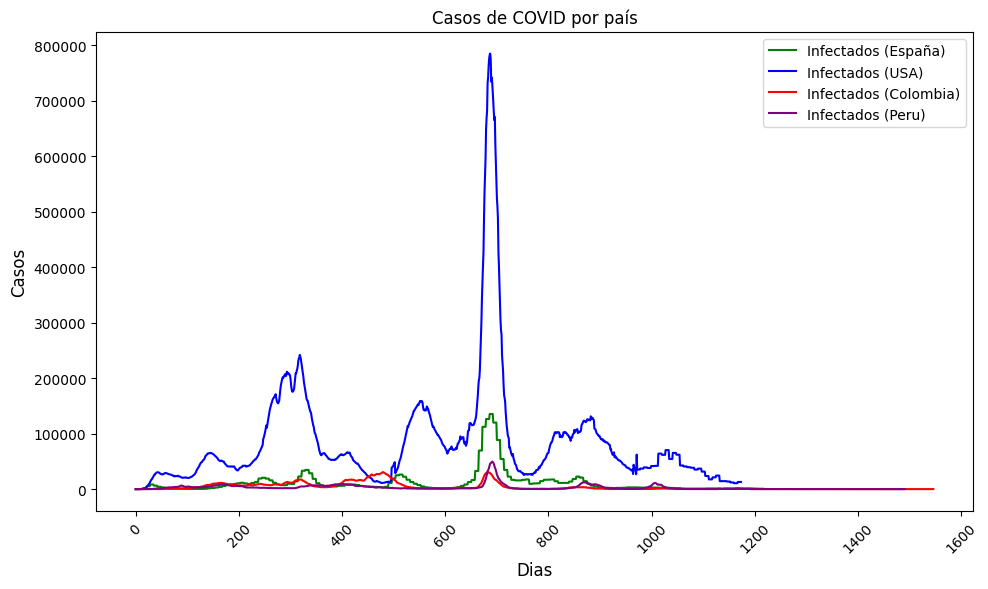

In [2]:
dataURL = 'https://raw.githubusercontent.com/kaamayao/data_model_project/refs/heads/main/data.csv'
data = pd.read_csv(dataURL)
data['Day'] = pd.to_datetime(data['Day'])
data = data[data['Cases'] != 0]

spain_data = format_data(
    data=data[data['Entity'] == 'Spain']['Cases'].values,
    color='g',
    label='Infectados (España)',
    total_pop=47374416
)

us_data = format_data(
    data=data[data['Entity'] == 'United States']['Cases'].values,
    color='b',
    label='Infectados (USA)',
    total_pop=331002651
)

col_data = format_data(
    data=data[data['Entity'] == 'Colombia']['Cases'].values,
    color='r',
    label='Infectados (Colombia)',
    total_pop=50882891
)


peru_data = format_data(
    data=data[data['Entity'] == 'Peru']['Cases'].values,
    color='purple',
    label='Infectados (Peru)',
    total_pop=32971710
)

plot_infected_data([spain_data, us_data, col_data, peru_data], "Casos de COVID por país")

Para crear el modelo, se centra el estudio en un caso en particular. En este caso la data sobre la cual se va a crear el modelo es la de Colombia

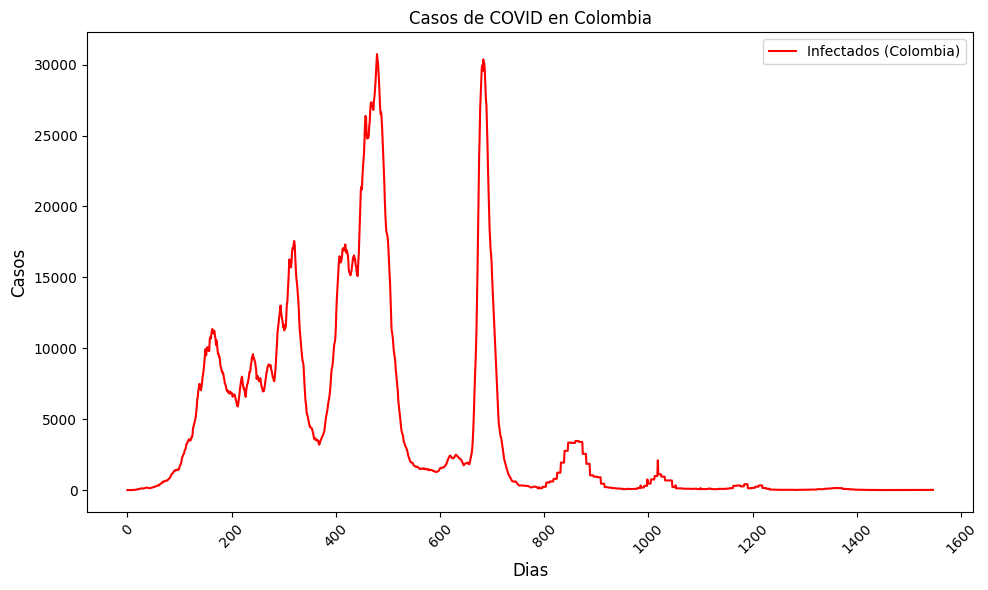

In [3]:
plot_infected_data([col_data],"Casos de COVID en Colombia")
real_data = col_data

## 2. Modelos implementados con comparación

### 2.1 Modelo SIR

Este modelo es descrito como:

*   `S` son los individuos que son susceptibles a ser infectados y no tienen inmunidad.
*   `I` número de individuos contagiados.
*   `R` número de individuos que son infectados, han sido curados, y no
*   `beta` representa la tasa de transmisión
*   `gamma` representa la tasa de recuperación




In [4]:
def sir_model(y, t, beta, gamma, N):
    [S, I, R] = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

Resuelve el modelo `SIR` utilizando la integración numérica con 'odeint'. Se formatean los datos modelados de las poblaciones `susceptible`(S), `infectada`(I) y `recuperada`(R) para generar un gráfico comparando los datos de infectados del modelo con los datos reales. Se espera que este interactue con la interfaz gráfica de `ipywidgets` para que se puedan modifica los parámetros de  `tasa de transimisión` (β) , `tasa de recuperación` (γ) y el de `número de días` (t)  

In [5]:
def plot_model_sir_model(beta, gamma, days):
    data_real=format_data(real_data['data'][0:days], 'r', 'Infectados (Real)', real_data['total_pop'])
    N = data_real['total_pop']/25
    I0 = real_data['data'][0]
    R0 = 0
    S0 = N - I0 - R0

    initial_conditions = [S0, I0, R0]
    days = np.linspace(0, len(data_real['data']), len(data_real['data']))
    solution = odeint(sir_model, initial_conditions, days,
                      args=(beta, gamma, N))
    S, I, R = solution.T

    r2 = r2_score(data_real['data'], I)
    print(f"R²: {r2:.3f}")

    format_model_data_S = format_data(S, 'purple', 'Susceptibles (SIR)', N)
    format_model_data_I = format_data(I, 'g', 'Infectados (SIR)', N)
    format_model_data_R = format_data(R, 'b', 'Recuperados (SIR)', N)
    Re = (beta * S[0]) / (gamma * N)

    plot_infected_data([ format_model_data_I,  data_real], "Comparativa con datos reales"+ f". R^2: {r2:.3f}")
    print(" ")
    plot_infected_data([ format_model_data_S, format_model_data_I, format_model_data_R],
                       "Gráfica del modelo SIR. Re: "+ '{0:.{1}f}'.format(Re, 2))

Utilizando ipywidgets se crea una interfaz interactiva para controlar los parámetros de un modelo SEIR y visualizar los resultados en tiempo real. Se generan tres deslizadores: uno para el parámetro de `tasa de transmisión (beta)` con un valor inicial de 0.3, otro para la `tasa de recuperación (gamma)` con un valor inicial de `0.07`, y uno más para seleccionar el `número de días (t)` con un valor inicial de 315. La visualización del modelo se actualiza de forma interactiva, mostrando el gráfico que compara el modelo SEIR con los datos reales.

In [6]:
beta_slider = widgets.FloatSlider(value=0.2, min=0.01, max=0.5, step=0.01, description='Beta (β):')
gamma_slider = widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description='Gamma (γ):')
days_slider = widgets.IntSlider(value=220, min=0, max=len(real_data['data']), description='Days(t): ')
interactive_plot = widgets.interactive(plot_model_sir_model,
                  beta=beta_slider,
                  gamma=gamma_slider,
                  days=days_slider
                )

display(interactive_plot)

interactive(children=(FloatSlider(value=0.2, description='Beta (β):', max=0.5, min=0.01, step=0.01), FloatSlid…

### 2.2 Modelo SEIR





Este módelo descrito como:

*   `S` son los individuos que son susceptibles a ser infectados y no tienen inmunidad.
*   `I` número de individuos contagiados.
*   `I` número de individuos expuestos.
*   `R` número de individuos que son infectados, han sido curados, y no
*   `beta` representa la tasa de transmisión
*   `gamma` representa la tasa de recuperación
*   `sigma` representa la tasa de en la que los individuos expuestos se vuelven contagiosos

In [7]:
def seir_model(y, t, beta, gamma, mu, lamb, k):
    S, E, I, R = y
    dSdt = -beta * S * I + lamb + mu * S
    dEdt = beta * S * I - (mu + k) * E
    dIdt = k * E - (gamma + mu) * I
    dRdt = gamma * I - mu * R
    return [dSdt, dEdt, dIdt, dRdt]

Resuelve el modelo SEIR utilizando la integración numérica con odeint. Se formatean los datos modelados de las poblaciones susceptible (`S`), expuesta (`E`), infectada (`I`) y recuperada (`R`) para generar un gráfico que compare los datos de infectados del modelo con los datos reales. Se espera que este modelo interactúe con la interfaz gráfica de `ipywidgets`, lo que permitirá modificar los parámetros de tasa de transmisión (`beta`), tasa de recuperación (`gamma`), tasa de exposición (`sigma`) y el número de días (`t`).

In [8]:
def calculate_R0(beta, gamma, mu, lambd, k):
    return (k * beta * lambd) / (mu * (k + mu) * (gamma + mu))


def plot_model_seir_model(beta, gamma, mu, lambd, k, t):
    R0 = calculate_R0(beta, gamma, mu, lambd, k)

    print(f"R0 (Basic Reproduction Number) = {R0:.2f}")

    N = real_data['total_pop']/1200
    data = real_data['data'][0:t]
    S0 = data[0]
    I0 = 0
    E0 = N - I0
    R0 = 0
    y0 = [S0, E0, I0, R0]
    t = np.linspace(0, t, t)
    sol = odeint(seir_model, y0, t, args=(beta, gamma, mu, lambd, k))

    [S, E, I, R] = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3]
    format_model_data_S = format_data(S, 'purple', 'Susceptibles (SEIR)', N)
    format_model_data_E = format_data(E, 'black', 'Expuesto (SEIR)', N)
    format_model_data_I = format_data(I, 'g', 'Infectado (SEIR)', N)
    format_model_data_R = format_data(R, 'b', 'Recuperado (SEIR)', N)
    error_r2 = r2_score(data, I)
    plot_model_real_data_SEIR(data, I,  t, beta, gamma, mu, lambd, k, error_r2)
    print(' ')
    plot_infected_data_components([ format_model_data_S,  format_model_data_E,
                                    format_model_data_I, format_model_data_R],
                                    "Gráfica del modelo SIRV")


Utilizando `ipywidgets` se crea una interfaz interactiva para controlar los parámetros de un `modelo SEIR` y visualizar los resultados en tiempo real. Se generan tres deslizadores: uno para el parámetro de `tasa de transmisión (beta)` con un valor inicial de 0.35, otro para la `tasa de recuperación (gamma)` con un valor inicial de 0.0714, y uno más para seleccionar el número de días (t) con un valor inicial de 315, este valor permite seleccionar cuántos días de la data real se utilizarán para la comparación con el modelo. La visualización del modelo se actualiza de forma interactiva, mostrando el gráfico que compara el `modelo SEIR` con los datos reales.

In [9]:
beta_slider_seir = widgets.FloatSlider(value=0.3, min=0.01, max=0.5, step=0.01, description='Beta:')
gamma_slider_seir = widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description='Gamma:')
mu_slider_seir = widgets.FloatSlider(value=0.01, min=0.01, max=1, step=0.01, description='mu:')
lambda_slider_seir = widgets.FloatSlider(value=0.0002, min=0.0001, max=0.1, step=0.0001, description='Lambda:')
k_slider_seir = widgets.FloatSlider(value=0.2, min=0.01, max=1, step=0.01, description='K:')
days_slider_seir = widgets.IntSlider(value=220, min=0, max=len(real_data['data']), description='Dias: ')

interactive_plot_seir = widgets.interactive(plot_model_seir_model,
                                            beta=beta_slider_seir,
                                            gamma=gamma_slider_seir,
                                            mu=mu_slider_seir,
                                            lambd=lambda_slider_seir,
                                            k=k_slider_seir,
                                            t=days_slider_seir
                                        )
display(interactive_plot_seir)


interactive(children=(FloatSlider(value=0.3, description='Beta:', max=0.5, min=0.01, step=0.01), FloatSlider(v…

### 2.3 Modelo SIRV

Este modelo es descrito como:

*   `S` son los individuos susceptibles.
*   `I` es el número de individuos infectados.
*   `V` es el número de individuos vacunados o inmunizados
*   `beta` representa la tasa de transmisión.
*  `gamma` representa la tasa de recuperación.
*   `v` representa la tasa a la que los individuos infectados se convierten en inmunizados o vacunados

In [10]:
def sirv_model(y, t, N, beta, gamma, v):
    S, I, R, V = y
    dSdt = -beta * S * I / N - v * S
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    dVdt = v * S
    return [dSdt, dIdt, dRdt, dVdt]

Esta función ajusta un modelo `SIRV` (`Susceptibles`, `Infectados`, `Recuperados`, `Vacunados`) a datos reales utilizando un enfoque de minimización de error cuadrático. Se optimiza los parámetros del modelo (`beta`, `gamma` y `v`) para minimizar este error.

La solución obtenida se usa para calcular el error `R²` y para graficar la comparación entre los datos reales y la predicción del modelo ajustado.

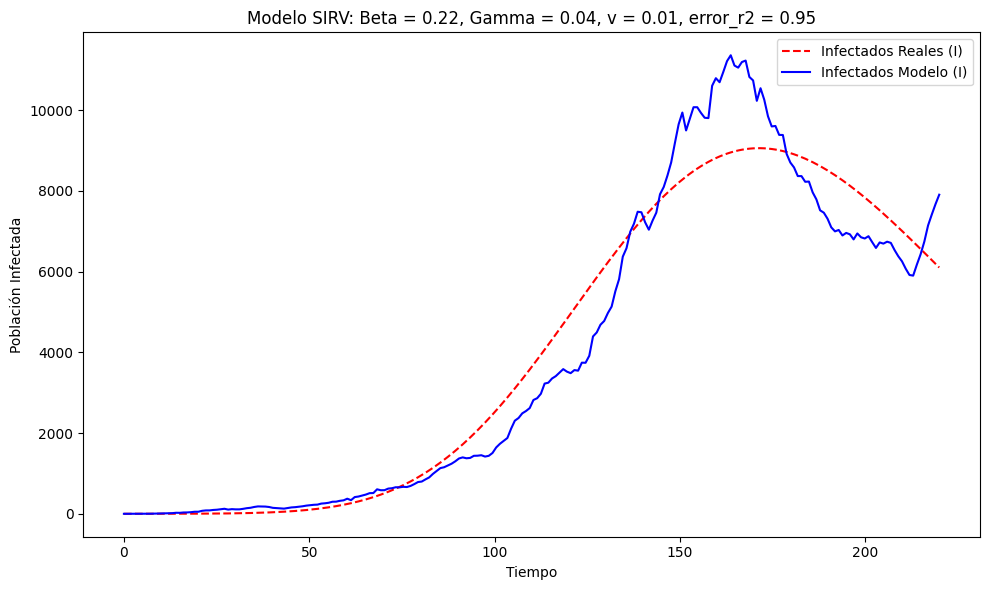

 
R²: 0.948


In [11]:
def fit_sirv_model(real_data):
    def objective(params, t, data, N):
        beta, gamma, v = params
        I0 = data[0]
        S0 = N - I0
        R0 = 0
        V0 = 0
        y0 = [S0, I0, R0, V0]
        sol = odeint(sirv_model, y0, t, args=(N, beta, gamma, v))
        error = np.sum((sol[:, 1] - data)**2)
        return error

    initial_guess = [0.3, 0.1, 0.01]
    data = real_data['data'][0:220]
    t = np.linspace(0, len(data), len(data))
    N = real_data['total_pop']
    result = minimize(objective, initial_guess, args=(t, data, N),
                      bounds=((0, 1), (0, 1), (0.01,1)))
    beta_opt, gamma_opt, v_opt = result.x
    I0 = data[0]
    S0 = N - I0
    R0 = 0
    V0 = 0
    y0 = [S0, I0, R0, V0]
    sol = odeint(sirv_model, y0, t, args=(N, beta_opt, gamma_opt, v_opt))
    error_r2 = r2_score(data, sol[:, 1])
    plot_model_real_data(sol[:, 1],  data, np.linspace(0, len(data), len(data)), beta_opt, gamma_opt, v_opt, error_r2)
    print(' ')
    print(f"R²: {error_r2:.3f}")
    return beta_opt, gamma_opt, v_opt

beta_opt, gamma_opt, v_opt = fit_sirv_model(real_data)

Resuelve el modelo SEIR utilizando la integración numérica con odeint. Se formatean los datos modelados de las poblaciones susceptible (`S`), infectada (`I`), recuperada (`R`), y vacunada (`V`)  para generar un gráfico que compare los datos de infectados del modelo con los datos reales. Se espera que este modelo interactúe con la interfaz gráfica de `ipywidgets`, lo que permitirá modificar los parámetros de tasa de transmisión (`beta`), tasa de recuperación (`gamma`), tasa de exposición (`sigma`), la tasa a la que los individuos infectados se convierten en inmunizados o vacunados (`v`) y el número de días (`t`).

In [12]:
def plot_model_sirv_model(beta, gamma, v, t):
    N = real_data['total_pop']
    data = real_data['data'][0:t]
    I0 = data[0]
    S0 = N - I0
    R0 = 0
    V0 = 0
    y0 = [S0, I0, R0, V0]
    t = np.linspace(0, t, t)
    sol = odeint(sirv_model, y0, t, args=(N, beta, gamma, v))

    [S, I, R, V] = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3]
    format_model_data_S = format_data(S, 'purple', 'Susceptibles (SEIR)', N)
    format_model_data_I = format_data(I, 'black', 'Infectados (SEIR)', N)
    format_model_data_R = format_data(R, 'g', 'Recuperados (SEIR)', N)
    format_model_data_V = format_data(V, 'b', 'Vacunados (SEIR)', N)

    error_r2 = r2_score(data, I)
    plot_model_real_data(I,  data, t, beta, gamma, v, error_r2)
    print(' ')
    plot_infected_data_components([ format_model_data_S,  format_model_data_I,
                                    format_model_data_R, format_model_data_V],
                                    "Gráfica del modelo SIRV")

Utilizando `ipywidgets` se crea una interfaz interactiva para controlar los parámetros de un `modelo SIRV` y visualizar los resultados en tiempo real. Se generan tres deslizadores: uno para el parámetro de `tasa de transmisión (beta)`, `tasa de recuperación (gamma)`, `tasa a la que los individuos infectados se convierten en inmunizados o vacunados (v)` y `número de días (t)` con un valor inicial de `220`, este valor permite seleccionar cuántos días de la data real se utilizarán para la comparación con el modelo. Todos los paramétros inciales son los óptimos previamente calculados.

La visualización del modelo se actualiza de forma interactiva, mostrando el gráfico que compara el `modelo SEIR` con los datos reales.

In [13]:
beta_slider_sirv = widgets.FloatSlider(value=beta_opt, min=0.01, max=0.5, step=0.01, description='Beta (β):')
gamma_slider_sirv = widgets.FloatSlider(value=gamma_opt, min=0.01, max=0.5, step=0.01, description='Gamma (γ):')
v_slider_sirv = widgets.FloatSlider(value=v_opt, min=0.01, max=1, step=0.01, description='v (v):')
days_slider_sirv = widgets.IntSlider(value=220, min=0, max=500, description='Days (t): ')

interactive_plot_sirv = widgets.interactive(plot_model_sirv_model,
                                            beta=beta_slider_sirv,
                                            gamma=gamma_slider_sirv,
                                            v=v_slider_sirv,
                                            t=days_slider_sirv
                                        )

display(interactive_plot_sirv)


interactive(children=(FloatSlider(value=0.21650096575304698, description='Beta (β):', max=0.5, min=0.01, step=…

# Repositorio

https://github.com/kaamayao/data_model_project

# Bibliografía

1. Youssoufa Mohamadou, Aminou Halidou, and Pascalin Tiam Kapen. (2020). A review of mathematical modeling, artificial intelligence and datasets used in the study, prediction and management of covid-19. *Applied Intelligence*, 50(11), 3913–3925.

2. Mimmo Iannelli. (2005). The mathematical modeling of epidemics. *UNITEXT - La Matematica per il 3 piu 2*, 79.

3. W. O. Kermack and A. G. McKendrick. (1927). A contribution to the mathematical theory of epidemics. *Proceedings of the Royal Society of London. Series A, Containing Papers of a Mathematical and Physical Character*, 115(772), 700–721. Accessed: 04/05/2014 17:07.

4. Donald S. Burke. (2024). Origins of the problematic e in seir epidemic models. *Infectious Disease Modelling*, 9(3), 673–679.

5. Our World in Data. (2025). Covid-19 data. Recuperado de https://ourworldindata.org. Accessed: 2025-03-05.

6. Numeracy, Maths and Statistics - Academic Skills Kit. (n.d.). Coefficient of determination (r-squared). Accessed: 2025-03-06.

7. Ashish Tiwari. (2022). Chapter 2 - supervised learning: From theory to applications. In R. Pandey, S. Khatri, N. Kumar Singh, & P. Verma (Eds.), *Artificial Intelligence and Machine Learning for EDGE Computing*, 23–32. Academic Press.

8. Howard Weiss. (2013). The sir model and the foundations of public health. *Materials matem`atics*, 1–17. Accessed: 6 mar¸c 2025.

9. Gheondea and A. (2020). The classical sir model in epidemiology. *Gazeta Mathematica Seria A*, 38(Unknown Issue), 10–18.

10. Eric Comincini Cantillo, Jorge Homero Wilches Visbal, and Fernando Daniel Sarav´ı. (2021). Factores epidemiológicos r0 y re durante la covid-19: ¿qué son y en qué difieren? *Revista Cuidarte*, 12(1), e1393.

11. Muteb Faraj Alharthi. (2022). The basic reproduction number for the markovian sir-type epidemic models: Comparison and consistency. *Journal of Mathematics*, 2022:1925202. Received 19 May 2022; Revised 23 July 2022; Accepted 8 August 2022; Published 24 September 2022.

12. O. Babasola, O. Kayode, O.J. Peter, F.C. Onwuegbuche, and F.A. Oguntolu. (2022). Time-delayed modelling of the covid-19 dynamics with a convex incidence rate. *Inform Med Unlocked*, 35, 101124. Epub 2022 Nov 8.

13. F. Gao. (2025). The study of covid-19 virus infection based on the seir model. *Theoretical and Natural Science*, 68(1), 46–56.

14. James Holland Jones. (2007). Notes on r0. *Department of Anthropological Sciences, Stanford University*. Accessed: 2025-03-07.

15. Reinhard Schlickeiser and Martin Kr¨oger. (2021). Analytical modeling of the temporal evolution of epidemics outbreaks accounting for vaccinations. *Physics*, 3(2), 386–426.

16. D. Reid and D. Goldberg. (2012). 68 - epidemiology and control of community infections. In D. Greenwood, M. Barer, R. Slack, & W. Irving (Eds.), *Medical Microbiology* (Eighteenth Edition), 708–717. Churchill Livingstone, Edinburgh.

17. MathWorks. (2025). Nonlinear least squares (curve fitting). Accessed: 2025-03-07.

18. SciPy Developers. (2025). scipy.integrate.odeint. Retrieved from https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html. Accessed: 2025-03-07.

19. Alexis Akira Toda. (2020). Susceptible-infected-recovered (sir) dynamics of covid-19 and economic impact.

20. Qiang Chen and Ji Qi. (2023). How much should we trust r2 and adjusted r2: evidence from regressions in top economics journals and monte carlo simulations. *Journal of Applied Economics*, 26(1), 2207326.

21. Ole N. Bjørnstad, Kathleen Shea, Martin Krzywinski, et al. (2020). Modeling infectious epidemics. *Nature Methods*, 17, 455–456.
